# Heart Failure Mortality Predicion

The following dataset contains 23 attributes monitored in hospitals for patients with heart failure issues.  
The target variable is *Mortality* which is tagged as 0/1 i.e *Died= 0 and Alive= 1*  
Since this problem is a binary classification, we will be using binary classifiers  

In [35]:
## Importing all the necessary modules
### General Packages
import numpy as np
import pandas as pd
import pandas_profiling as pp
from skimpy import clean_columns
from collections import Counter
import joblib as jb

### Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Machine Learning Packages
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from imblearn.over_sampling import ADASYN
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,plot_roc_curve,plot_confusion_matrix
from sklearn.inspection import permutation_importance

## Step-1 : Load the dataset

In [2]:
mortality_data = pd.read_csv("../../data/Mortality_dataset.csv")
mortality_data.shape

(368, 23)

In [3]:
## Lets check the basic data distribution
mortality_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 23 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   ID                                                                                        368 non-null    int64  
 1   Age                                                                                       368 non-null    int64  
 2   Gender                                                                                    368 non-null    object 
 3   Locality                                                                                  368 non-null    object 
 4   Marital status                                                                            368 non-null    object 
 5   Life.Style                                               

##### Inference : All the data is cleaned and devoid of null (NA) values  
##### Next steps include distribution overview in form of reports

In [5]:
## Cleaning out the column names with standard snake-case, due to massive irregularity
mortality_data = clean_columns(mortality_data)

0 column names have been cleaned

In [6]:
mortality_data.columns

Index(['id', 'age', 'gender', 'locality', 'marital_status', 'life_style',
       'sleep', 'depression', 'smoking', 'family_history', 'diabetes', 'bp',
       'esr', 'wbc', 'rbc', 'hemoglobin', 'platelet_count', 'others', 'co',
       'diagnosis', 'chol', 'mortality', 'follow_up'],
      dtype='object')

## Step-2a : Generate a preview report for the data distribution

#### Using Pandas-Profiling for such scenario

In [7]:
profile = pp.ProfileReport(mortality_data)
profile.to_file("mortality_feature_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\nabar\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

##### Inference : 
1. From the "mortality_feature_report.html" Report we can figure out the correlation heatmap as well as the univariate analysis
2. Columns like Marital status,Depression,Gender,Locality,Family History as well as the Target Variable "Mortality" are highly imbalance

## Step-3a : Splitting the data into X & Y

In [8]:
X = mortality_data.drop(columns=["mortality"])
y = mortality_data["mortality"]

## Step-3b : Run Feature Encoding operation

In [9]:
## figure out the variables that are categorical
cat_cols = list(X.select_dtypes(include=['object']).columns)

In [10]:
## Copy and preserve the main dataframe
X_encoded = X.copy()

## Instantiate an encoder
encoder = LabelEncoder()

X_encoded[cat_cols] = X_encoded[cat_cols].apply(encoder.fit_transform)

## Step-3c : Run Feature Selection techniques

### Correlation check

<AxesSubplot:>

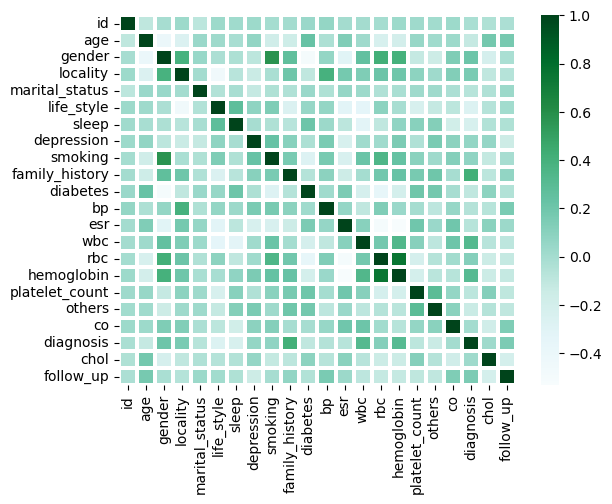

In [12]:
sns.heatmap(X_encoded.corr(),linewidths=1.5,cmap='BuGn')

### RFE Check

In [13]:
## Since the data is very non linear in nature, assigin a small tree algo for feature elimination
dt = DecisionTreeClassifier()

selector = RFECV(dt,step=5,cv=20)
selector = selector.fit(X_encoded.drop(columns="id"), y)

print("===== Selected features as per information Gain =====")
list(zip(X_encoded.drop(columns="id").columns,selector.support_,selector.ranking_))

===== Selected features as per information Gain =====


[('age', True, 1),
 ('gender', True, 1),
 ('locality', False, 3),
 ('marital_status', False, 3),
 ('life_style', False, 3),
 ('sleep', False, 3),
 ('depression', False, 2),
 ('smoking', True, 1),
 ('family_history', False, 2),
 ('diabetes', False, 2),
 ('bp', False, 3),
 ('esr', False, 2),
 ('wbc', False, 2),
 ('rbc', True, 1),
 ('hemoglobin', True, 1),
 ('platelet_count', True, 1),
 ('others', True, 1),
 ('co', True, 1),
 ('diagnosis', True, 1),
 ('chol', True, 1),
 ('follow_up', True, 1)]

##### Inference:
1. RBC is highly correlated with Hemoglobin ==> Keeping RBC (as we all know that RBC is the main content of Haemoglobin)
2. Locality is highly correlated with Lifestyle ==> Keeping Locality (Lifestyle being only true and false doesnt give much info)
3. Sleep is highly correlated with depression ==> Keeping Sleep (as depression is also hihgly imbalance)

## Step-3d : Feature Finalization & Validation

In [14]:
### Dropping the columns as discussed earlier
print(" === Data Shape before dropping === ",X_encoded.shape)
X_final = X_encoded.drop(columns=['hemoglobin','life_style','depression'])
print(" === Data Shape after dropping === ",X_final.shape)

 === Data Shape before dropping ===  (368, 22)
 === Data Shape after dropping ===  (368, 19)


## Step-3e : Handling Class Imbalance

In [15]:
### Using Adasyn for its high performance data reproduction
print('Original dataset shape %s' % Counter(y))

ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X_final.drop(columns=["id"]), y)

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 288, 1: 80})
Resampled dataset shape Counter({0: 288, 1: 281})


## Step-4a : Splitting the data into train test module

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)

In [17]:
print("=== length of the train data ===",Counter(y_train))
print("=== length of the test data ===",Counter(y_test))

=== length of the train data === Counter({0: 201, 1: 180})
=== length of the test data === Counter({1: 101, 0: 87})


## Step-4b : Building the ML Model

### Decision trees

In [18]:
## For training aspect
dt_default = DecisionTreeClassifier()

dt_default.fit(X_train,y_train)
train_preds = dt_default.predict(X_train)

print("===== METRIC OUTPUT =====")
print("confusion_matrix ==>",confusion_matrix(y_train,train_preds))
print("accuracy_score ==>",accuracy_score(y_train,train_preds))
print("precision_score ==>",precision_score(y_train,train_preds))
print("recall_score ==>",recall_score(y_train,train_preds))

===== METRIC OUTPUT =====
confusion_matrix ==> [[201   0]
 [  0 180]]
accuracy_score ==> 1.0
precision_score ==> 1.0
recall_score ==> 1.0


In [19]:
## For Testing aspect
test_preds = dt_default.predict(X_test)

print("===== METRIC OUTPUT =====")
print("confusion_matrix ==>",confusion_matrix(y_test,test_preds))
print("accuracy_score ==>",accuracy_score(y_test,test_preds))
print("precision_score ==>",precision_score(y_test,test_preds))
print("recall_score ==>",recall_score(y_test,test_preds))

===== METRIC OUTPUT =====
confusion_matrix ==> [[84  3]
 [ 2 99]]
accuracy_score ==> 0.973404255319149
precision_score ==> 0.9705882352941176
recall_score ==> 0.9801980198019802


##### Inference:
1. Model looks like a perfect fit..

OR is it overfit?
Lets try out a Hyperparameter tuned DT

### Decision trees w/ Hyp. Param Tuned

In [41]:
## For training aspect
dt_default = DecisionTreeClassifier()

search = RandomizedSearchCV(dt_default,param_distributions={'criterion':['gini','entropy'],'splitter' : ["best", "random"],'min_samples_split':range(2,20,2)})

search.fit(X_train,y_train)
train_preds = search.best_estimator_.predict(X_train)

print("===== METRIC OUTPUT =====")
print("confusion_matrix ==>",confusion_matrix(y_train,train_preds))
print("accuracy_score ==>",accuracy_score(y_train,train_preds))
print("precision_score ==>",precision_score(y_train,train_preds))
print("recall_score ==>",recall_score(y_train,train_preds))

===== METRIC OUTPUT =====
confusion_matrix ==> [[201   0]
 [  0 180]]
accuracy_score ==> 1.0
precision_score ==> 1.0
recall_score ==> 1.0


In [42]:
## For Testing aspect
test_preds = search.best_estimator_.predict(X_test)

print("===== METRIC OUTPUT =====")
print("confusion_matrix ==>",confusion_matrix(y_test,test_preds))
print("accuracy_score ==>",accuracy_score(y_test,test_preds))
print("precision_score ==>",precision_score(y_test,test_preds))
print("recall_score ==>",recall_score(y_test,test_preds))

===== METRIC OUTPUT =====
confusion_matrix ==> [[84  3]
 [ 2 99]]
accuracy_score ==> 0.973404255319149
precision_score ==> 0.9705882352941176
recall_score ==> 0.9801980198019802


In [43]:
search.best_estimator_

DecisionTreeClassifier(criterion='entropy', min_samples_split=6)

Plot for the Confusion metrics


C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


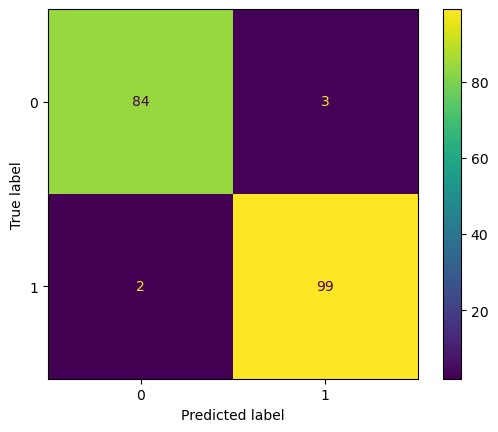

In [44]:
### Final test O/P Confusion matrix
print("Plot for the Confusion metrics")
plot_confusion_matrix(search.best_estimator_,X_test,y_test)

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


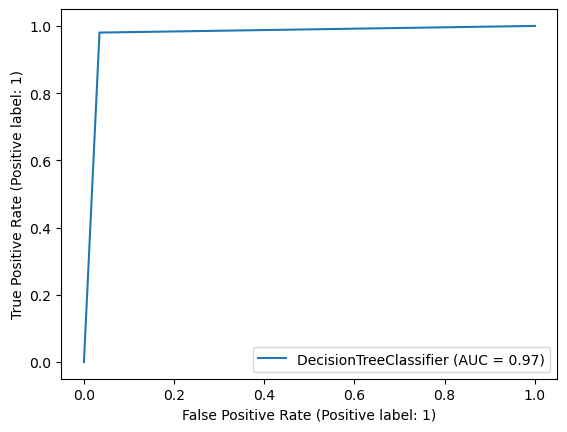

In [45]:
### Final test on the ROC-AUC curve
plot_roc_curve(search.best_estimator_,X_test,y_test)

##### Inference:
1. This base Decision Tree model, with entropy formula works greatly when seen in the following data points.
2. Good fit with very minimal FP/FN
3. ROC curve also looks handsomely good with good stability.

## Step-5 : Saving the models for future use.

In [46]:
## Saving our encoder
file_path = "../../models/lencoder.h5"
jb.dump(encoder,file_path)

['../../models/lencoder.h5']

In [47]:
## saving our decision tree models
file_path = "../../models/mortality_model.h5"
jb.dump(search.best_estimator_,file_path)

['../../models/mortality_model.h5']

## Step-6 : Checking for Feature Importances

In [48]:
perm_feat_imp = permutation_importance(search.best_estimator_, X_test, y_test,n_repeats=30,random_state=0)

<AxesSubplot:title={'center':'::: Decision Tree Model Feature Importance :::'}>

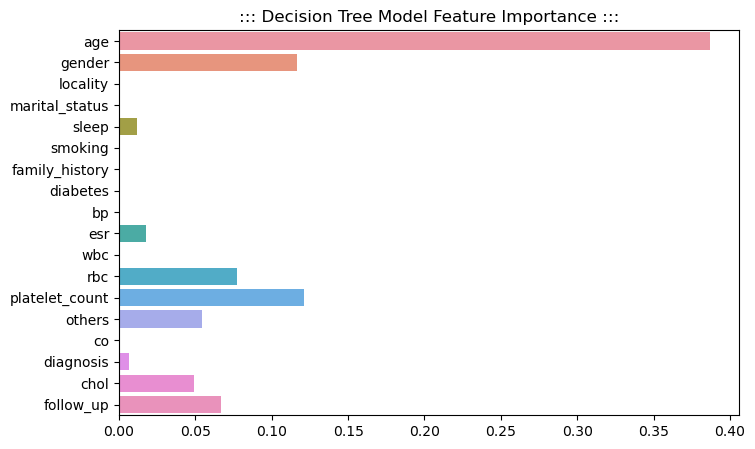

In [49]:
plt.figure(figsize=(8,5))
plt.title("::: Decision Tree Model Feature Importance :::")
sns.barplot(x=perm_feat_imp.importances_mean,y=X_test.columns)

## Step-6 : Revisiting the Whole workflow

1. Loading the data to see the whole data information. (df.info())
2. Since the column names where extremely unhygenic, we used skimpy to clean up the columns in a much standardized way.
3. Use Pandas profiling to create a historical data report w/ distributions and pre-checks.
4. We use the report to deduce the initial inferences ==> such as massive imbalances and correlations.
5. Feature Selection/Validation using Correlation plot on the X's and Recursive Feature Elimination (RFE) to figure out the variable that are pre-necessary, and encoded using a label encoder.
6. Split the data into Train & Test and start building the model, we have built a model w/ multiple hypertuning procedures.
7. All the models are saved out for future reference.
8. Checked out the permutation feature importance to see the actual distribution of the features and we see many un-necessary features.